# Housing Price Prediction

## Import Libraries

In [200]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

## Data Loading

In [201]:
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [202]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data Cleaning

In [203]:
duplicate = df[df.duplicated()]
duplicate

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


No duplicate data found

In [204]:
null = df.isnull().sum().sort_values(ascending=False)

In [205]:
print (null[null > 0])

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


From isnull function it seems that our data has several missing values.</br>
But looking closely into the data_description file, some columns has NA values that is not missing values. </br>
For example, please look at the Alley data description, the NA value just means that there is no alley access to the property. </br>
Therefore several of these missing values will not be treated of missing values and will be imputed with the None values.

In [206]:
cat_col = [col for col in df.columns if df[col].dtypes == 'O']

cat_col

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [207]:
num_col = df.select_dtypes(include=np.number).columns.tolist()
num_col

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

In [208]:
df_cleaned = df.copy()

In [209]:
for cat in cat_col:
    df_cleaned[cat].fillna('None',inplace=True)

In [210]:
df_cleaned['GarageYrBlt'].fillna(df_cleaned.YearBuilt, inplace = True)


In [211]:
for num in num_col:
    df_cleaned[num].fillna(df_cleaned[num].median(),inplace=True)

In [212]:
df_cleaned.drop(columns='Id',inplace=True)

In [213]:
df_cleaned

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,MnPrv,None,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,4,2010,WD,Normal,142125


## Data Exploration

### Explore Sale Price Feature

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<AxesSubplot:>

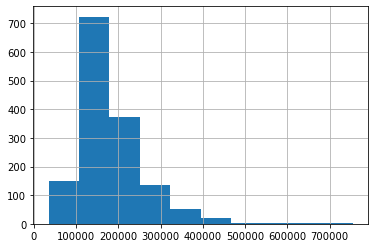

In [214]:
print(df_cleaned['SalePrice'].describe())
df_cleaned['SalePrice'].hist()

C:\Users\Wawan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SalePrice'>

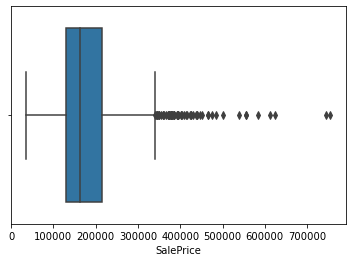

In [215]:
sns.boxplot(df_cleaned['SalePrice'])

From the exploration on the sale price feature, we gain insight that:</br>
1. Average of all sales price is 186.761
2. Majority of sales prices are within the range of 150.000 to 250.000
3. There is still outliers on the sales price data.

### Explore MSZoning Feature

In [216]:
dfzone = df_cleaned.groupby(['MSZoning']).agg({'SalePrice': [pd.Series.count, np.sum, np.mean]})
dfzone


SalePrice                          
             count        sum           mean
MSZoning                                    
C (all)         10     745280   74528.000000
FV              65   13910914  214014.061538
RH              16    2104934  131558.375000
RL            1151  219846749  191004.994787
RM             218   27537069  126316.830275

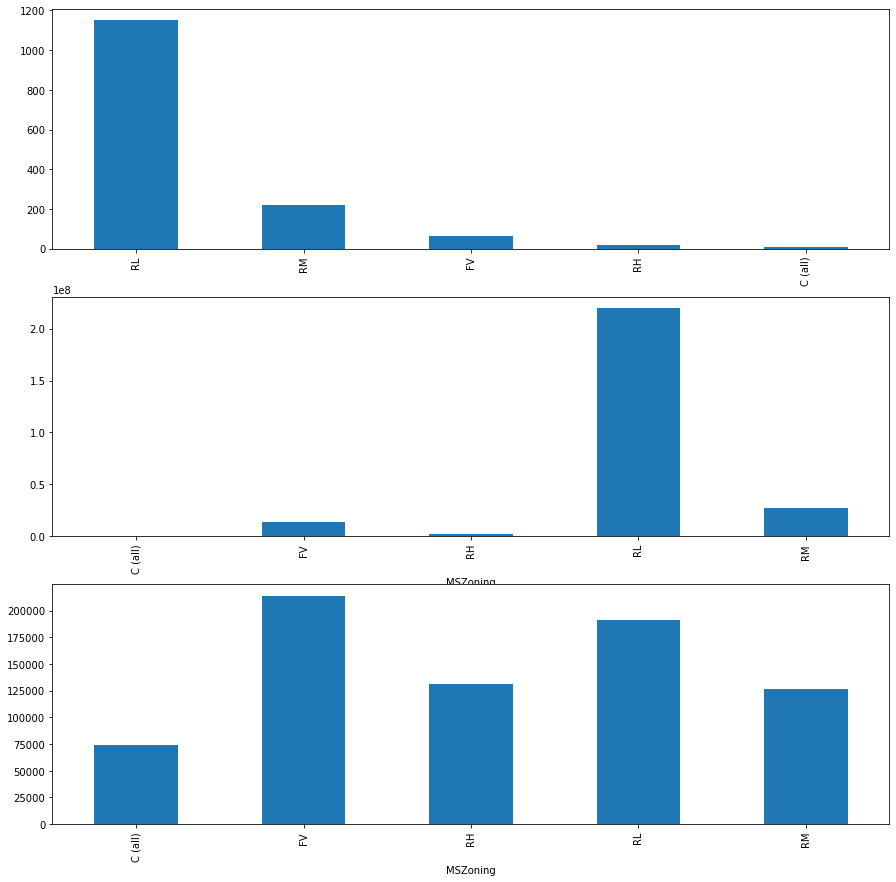

In [217]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (15,15))
df_cleaned.MSZoning.value_counts().plot(kind='bar',ax=axes[0])
df_cleaned.groupby('MSZoning').SalePrice.sum().plot(kind='bar',ax=axes[1])
df_cleaned.groupby('MSZoning').SalePrice.mean().plot(kind='bar',ax=axes[2])
plt.show()

From the MSZoning feature exploration we gain insight that:
1. The most frequent house sales are houses in the Residential Low Density (RL) zone, and the total sales on that zone is also the highest.
2. The most expensive houses are houses in the Floating Village Residential Zone as the average price of each house in that zone is the highest.

### Explore Street Feature

In [218]:
dfstreet = df_cleaned.groupby(['Street']).agg({'SalePrice': [pd.Series.count, np.sum, np.mean]})
dfstreet = dfstreet.head().style.format("{:,.0f}")
dfstreet


From the street feature we gain insight that the majority of the houses have paved road access and the average price of the houses that have paved road are higher.

### Explore Alley Feature

In [219]:
dfalley = df_cleaned.groupby(['Alley']).agg({'SalePrice': [pd.Series.count, np.sum, np.mean]})
dfalley = dfalley.head().style.format("{:,.0f}")
dfalley


From the alley feature, we gain insight that majority of the houses did not have access to an alley, and the houses that have access to an alley has a lower price than the houses that did not have access

## Explore GrLivArea Feature

In [220]:
df_cleaned.GrLivArea.describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

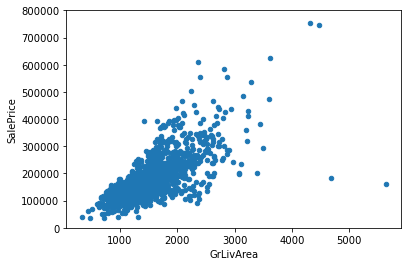

In [221]:
dfgrlivarea = pd.concat([df_cleaned['SalePrice'], df_cleaned['GrLivArea']], axis=1)
dfgrlivarea.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000));

From the Living Area feature we gain insight that the sale price is inline with the living area, however there are outliers that have large living area but low sale price. Hence we will remove that outliers

In [222]:
df_cleaned.drop(df_cleaned[(df_cleaned['GrLivArea']>4000) & (df_cleaned['SalePrice']<300000)].index, inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)

## Data Preprocessing

In [223]:
df_cleaned.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object

In [224]:
categorical = [col for col in df_cleaned.columns if df_cleaned[col].dtypes == 'O']

categorical

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [225]:
#Defining the One Hot Encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse = False)
# Applying One Hot Encoder to  data
ohe.fit(df_cleaned[categorical])
cat_ohe = ohe.transform(df_cleaned[categorical])
#Making DataFrame from encoded feature
ohe_df = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names(input_features = categorical))
#Combining original data with the encoded dataframe
df_encoded = pd.concat([df_cleaned, ohe_df], axis=1).drop(columns = categorical, axis=1)

In [226]:
df_encoded

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1454,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1455,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1456,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [227]:
#Define X and Y
y = df_encoded['SalePrice'].values
X = df_encoded.drop(columns=['SalePrice'],axis=1).values

In [228]:
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Model Defining
We will be using pipeline in this modelling to scale and train the data.

In [229]:
#Defining Model Pipeline
pipe_rf = Pipeline([('scl', StandardScaler()), ('clf', RandomForestRegressor(random_state=42))])
pipe_gbr = Pipeline([('scl', StandardScaler()), ('clf', GradientBoostingRegressor(random_state=42))])
pipe_ada = Pipeline([('scl', StandardScaler()), ('clf', AdaBoostRegressor(random_state=42))])
pipe_bag = Pipeline([('scl', StandardScaler()), ('clf', BaggingRegressor(random_state=42))])
pipe_svr = Pipeline([('scl', StandardScaler()), ('clf', SVR())])
pipe_rdg = Pipeline([('scl', StandardScaler()), ('clf', Ridge(random_state=42))])
pipe_las = Pipeline([('scl', StandardScaler()), ('clf', Lasso(random_state=42))])
pipe_ela = Pipeline([('scl', StandardScaler()), ('clf', ElasticNet(random_state=42))])
pipe_xgb = Pipeline([('scl', StandardScaler()), ('clf', XGBRegressor(random_state=42))])
pipes = [pipe_rf,pipe_gbr,pipe_ada,pipe_bag,pipe_svr,pipe_rdg,pipe_las,pipe_ela,pipe_xgb]

In [230]:
grid_dict = {0: 'Random Forest',1:'Gradient Boost', 2:'ADA Boost', 3: 'Bagging Regressor',4:'Support Vector Machine',5:'Ridge Regression',6:'Lasso Regression',7:'ElasticNet',8:'XGBoost'}

## Model Training
We will train several models at once using the above defined pipeline and will choose model that have the highest r2 score

In [231]:
#Model training with hyperparameter tuning using gridsearchcv
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_pipe = ''
for idx, pipe in enumerate(pipes):
	print('\nEstimator: %s' % grid_dict[idx])	
	# Fit grid search	
	pipe.fit(X_train, y_train)
	# Predict on test data
	y_pred = pipe.predict(X_test)
	# Test evaluation metrics of model
	print('Test set r2 score: %.3f ' %r2_score(y_test, y_pred))
	print('Test set Mean Absolute Error (MAE): %.3f ' %mean_absolute_error(y_test, y_pred))
	print('Test set Mean Squared Error (MSE): %.3f ' %mean_squared_error(y_test, y_pred))
	print('Test set Root Mean Squared Error (RMSE): %.3f ' %mean_squared_error(y_test, y_pred,squared=False))
	# Track best (highest test accuracy) model
	if r2_score(y_test, y_pred) > best_acc:
		best_acc = r2_score(y_test, y_pred)
		best_pipe = pipe
		best_clf = idx
print('\nClassifier with best r2 score: %s' % grid_dict[best_clf])

Performing model optimizations...

Estimator: Random Forest
Test set r2 score: 0.894 
Test set Mean Absolute Error (MAE): 16770.641 
Test set Mean Squared Error (MSE): 586471326.766 
Test set Root Mean Squared Error (RMSE): 24217.170 

Estimator: Gradient Boost
Test set r2 score: 0.919 
Test set Mean Absolute Error (MAE): 15449.802 
Test set Mean Squared Error (MSE): 444668362.749 
Test set Root Mean Squared Error (RMSE): 21087.161 

Estimator: ADA Boost
Test set r2 score: 0.846 
Test set Mean Absolute Error (MAE): 21710.493 
Test set Mean Squared Error (MSE): 847897778.207 
Test set Root Mean Squared Error (RMSE): 29118.684 

Estimator: Bagging Regressor
Test set r2 score: 0.875 
Test set Mean Absolute Error (MAE): 18332.378 
Test set Mean Squared Error (MSE): 688960052.152 
Test set Root Mean Squared Error (RMSE): 26248.049 

Estimator: Support Vector Machine
Test set r2 score: -0.066 
Test set Mean Absolute Error (MAE): 57076.086 
Test set Mean Squared Error (MSE): 5885876334.088 
T

C:\Users\Wawan\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201211071154.26608, tolerance: 759446081.0754158
  model = cd_fast.enet_coordinate_descent(


Test set r2 score: 0.849 
Test set Mean Absolute Error (MAE): 18772.537 
Test set Mean Squared Error (MSE): 834740677.796 
Test set Root Mean Squared Error (RMSE): 28891.879 

Estimator: ElasticNet
Test set r2 score: 0.899 
Test set Mean Absolute Error (MAE): 17020.875 
Test set Mean Squared Error (MSE): 558307061.484 
Test set Root Mean Squared Error (RMSE): 23628.522 

Estimator: XGBoost
Test set r2 score: 0.899 
Test set Mean Absolute Error (MAE): 17041.735 
Test set Mean Squared Error (MSE): 560433482.018 
Test set Root Mean Squared Error (RMSE): 23673.476 

Classifier with best r2 score: Gradient Boost


From the model training it seems that Gradient Boosting has the highest r2 score compared to the other models

## Model Evaluation

In [232]:
y_pred = best_pipe.predict(X_test)

In [233]:
#Evaluation Metrics of Regression Model
print('R Squared score: %.3f ' %r2_score(y_test, y_pred))
print('Mean Absolute Error (MAE): %.3f ' %mean_absolute_error(y_test, y_pred))
print('Mean Squared Error (MSE): %.3f ' %mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE): %.3f ' %mean_squared_error(y_test, y_pred,squared=False))

R Squared score: 0.919 
Mean Absolute Error (MAE): 15449.802 
Mean Squared Error (MSE): 444668362.749 
Root Mean Squared Error (RMSE): 21087.161 


### Evaluation Metric Interpretation
1. R-Squared value of 0.89 would indicate that 89% of the variance of the dependent variable being studied is explained by the variance of the independent variable.
2. MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.
3.  RMSE is a quadratic scoring rule that also measures the average magnitude of the error. It’s the square root of the average of squared differences between prediction and actual observation.


## Model Inference
We will now test our model to the new test data

### Test Data Loading

In [247]:
#Load the Test Data
dftest = pd.read_csv('test.csv')
dftest.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [248]:
dftest

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


### Test Data Cleaning

In [249]:
#Check Missing Values
dftest.isnull().sum().sort_values(ascending = False)

PoolQC           1456
MiscFeature      1408
Alley            1352
Fence            1169
FireplaceQu       730
                 ... 
Electrical          0
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
SaleCondition       0
Length: 80, dtype: int64

In [250]:
cat_test = [col for col in dftest.columns if dftest[col].dtypes == 'O']

cat_test

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [251]:
num_test = dftest.select_dtypes(include=np.number).columns.tolist()
num_test

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [252]:
for cat in cat_test:
    dftest[cat].fillna('None',inplace=True)

In [253]:
dftest['GarageYrBlt'].fillna(dftest.YearBuilt, inplace = True)


In [254]:
for num in num_test:
    dftest[num].fillna(dftest[num].median(),inplace=True)

In [255]:
nulltest = dftest.isnull().sum().sort_values(ascending = False)
print (nulltest[nulltest > 0])

Series([], dtype: int64)


In [256]:
dftest.isnull().sum().sort_values(ascending=False)

Id               0
MSSubClass       0
GarageType       0
FireplaceQu      0
Fireplaces       0
                ..
MasVnrType       0
Exterior2nd      0
Exterior1st      0
RoofMatl         0
SaleCondition    0
Length: 80, dtype: int64

In [257]:
dftest

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,...,120,0,None,MnPrv,None,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,...,0,0,None,MnPrv,None,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,...,144,0,None,None,None,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,None,Reg,Lvl,AllPub,...,0,0,None,MnPrv,Shed,700,7,2006,WD,Normal


### Test Data PreProcessing

In [258]:
cat_ohe_test = ohe.transform(dftest[categorical])
#Making DataFrame from encoded feature
ohe_dftest = pd.DataFrame(cat_ohe_test, columns = ohe.get_feature_names(input_features = categorical))
#Combining original data with the encoded dataframe
dftest_encoded = pd.concat([dftest, ohe_dftest], axis=1).drop(columns = categorical, axis=1)

In [259]:
dftest_encoded

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,21.0,1936,4,7,1970,1970,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1455,2916,160,21.0,1894,4,5,1970,1970,0.0,252.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1456,2917,20,160.0,20000,5,7,1960,1996,0.0,1224.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1457,2918,85,62.0,10441,5,5,1992,1992,0.0,337.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [260]:
idtest = dftest_encoded['Id'].values
datatest = dftest_encoded.drop(columns = ['Id'], axis=1).values

In [261]:
y_pred_test = best_pipe.predict(datatest)

In [263]:
#Create Dataframe that consist of Passenger ID and the Survival Prediction
submission = pd.DataFrame({'Id': idtest,'SalePrice': y_pred_test})
submission

,Id,SalePrice
0,1461,122150.888559
1,1462,163304.240296
2,1463,180948.442337
3,1464,191026.464823
4,1465,196274.297323
...,...,...
1454,2915,82621.442476
1455,2916,80666.333303
1456,2917,150370.031615
1457,2918,119928.199653


In [264]:
#Save Submission to csv
submission.to_csv('house_price_submission.csv', index=False)